In [5]:
#Only run to mount google drive
#from google.colab import drive
#drive.mount('/content/drive/')

In [12]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG) #logging.INFO
logging.debug("test")
logging.info('test2')

DEBUG:root:test
INFO:root:test2


##1. Basic LLM Call

In [ ]:
import os
from openai import OpenAI
#0. Setting the OpenAI API key from google colab
#from google.colab import userdata
#os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
#1. GET your OpenAI API key from the OpenAI dashboard
api_key = os.getenv("OPENAI_API_KEY")
#2. Create a new OpenAI instance
client = OpenAI(api_key=api_key)
#3. Set the chat model
chat_model="gpt-4o-mini"

In [7]:
##LLM calls##
completion = client.chat.completions.create(
    model=chat_model,
    #user - query is the content
    #system  content - prompt engineering
    messages=[
        {"role": "system", "content": "You're a helpful assistant."},
        {
            "role": "user",
            "content": "Write a limerick about the Python programming language.",
        },
    ],
)

response = completion.choices[0].message.content
#response is a string
print(response)

In a world where code often snakes,  
Python glides with elegant wakes.  
With its syntax so neat,  
It can’t be beat,  
For both newbies and seasoned high stakes!


##2. Get Structured output from LLMs##

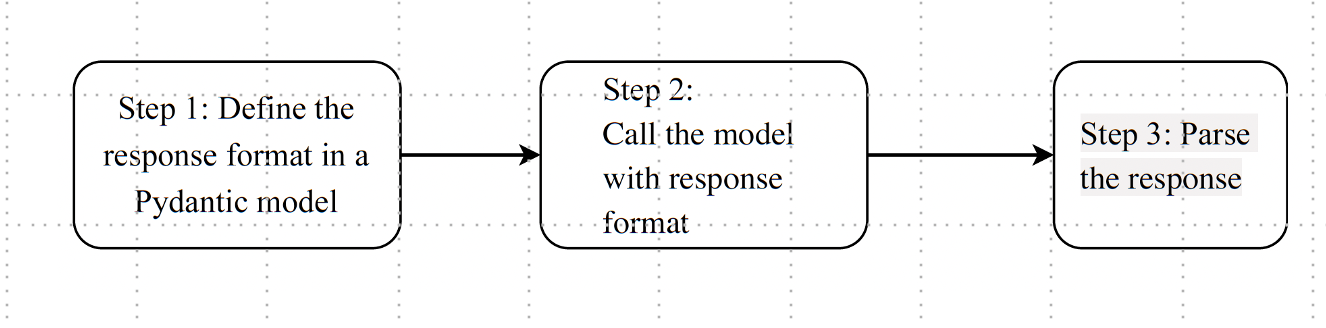

In [ ]:
##Get Structured output from LLMs##

# --------------------------------------------------------------
# Step 1: Define the response format in a Pydantic model
# --------------------------------------------------------------


class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[str]


# --------------------------------------------------------------
# Step 2: Call the model
# --------------------------------------------------------------

completion = client.beta.chat.completions.parse(
    model=chat_model,
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {
            "role": "user",
            "content": "Alice and Bob are going to a science fair on Friday.",
        },
    ],
    response_format=CalendarEvent,
)

# --------------------------------------------------------------
# Step 3: Parse the response
# --------------------------------------------------------------

event = completion.choices[0].message.parsed
print(event.name)
print(event.date)
print(event.participants)

Science Fair
Friday
['Alice', 'Bob']


## Tool Calling
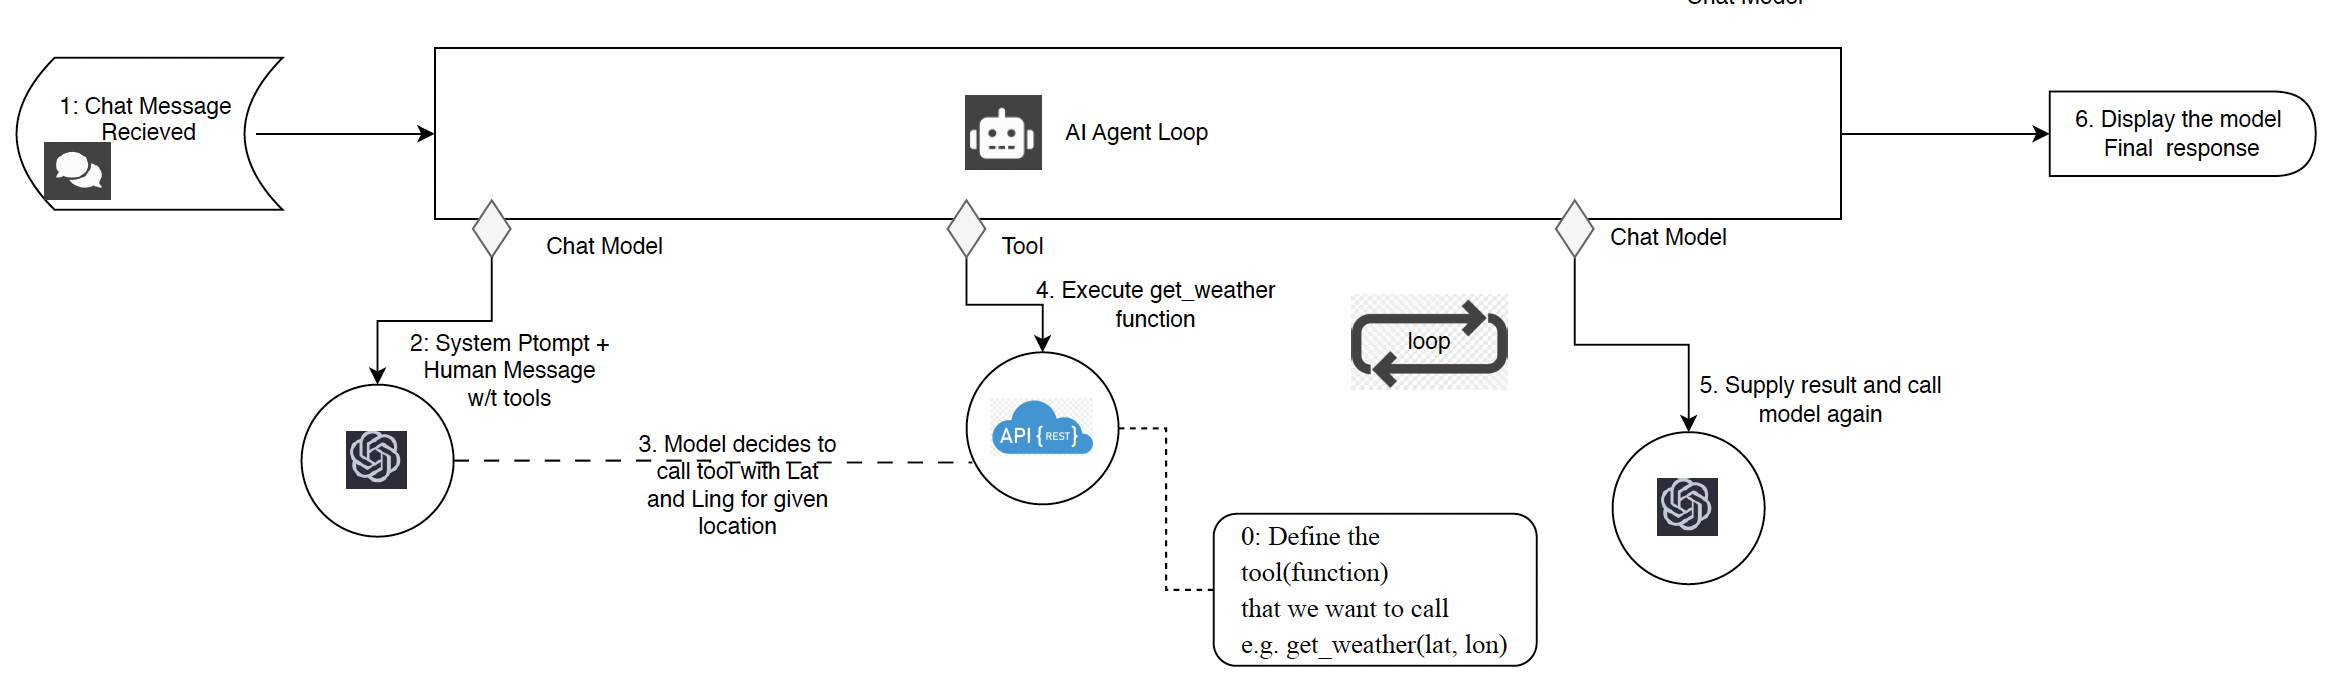

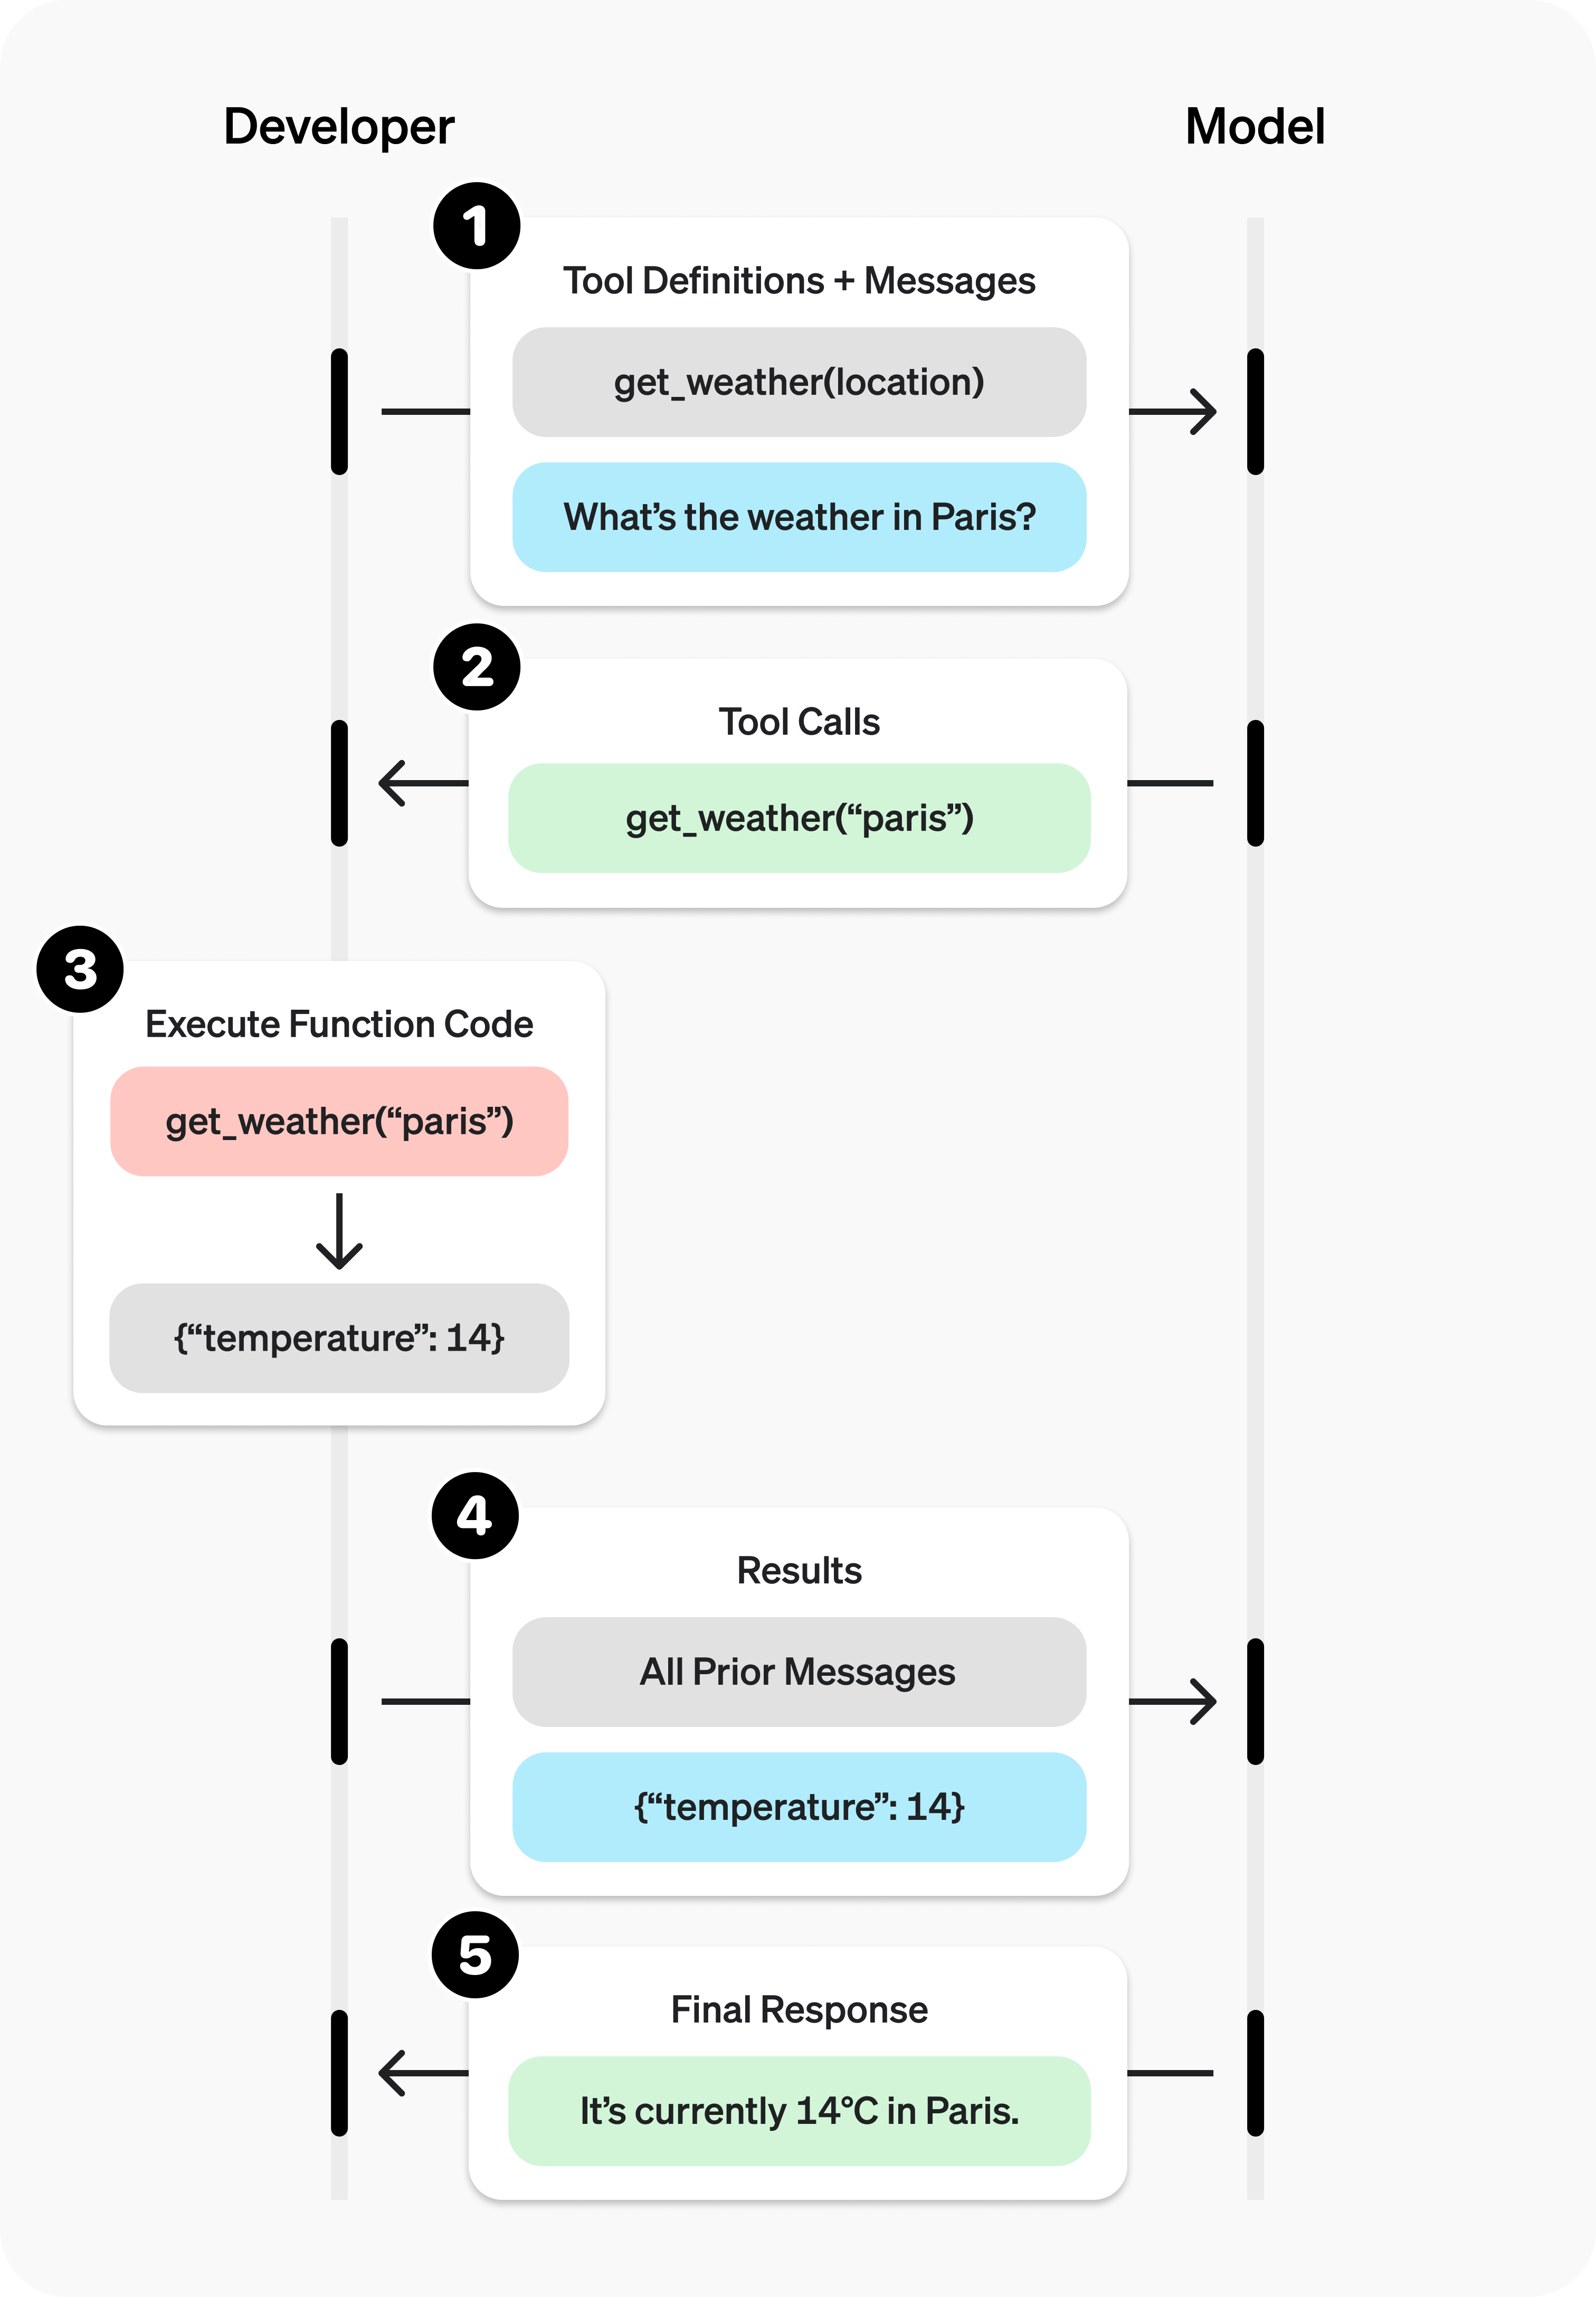

In [8]:
##Tools##
import json
import os

import requests
from pydantic import BaseModel, Field



"""
docs: https://platform.openai.com/docs/guides/function-calling
"""

# --------------------------------------------------------------
# Define the tool (function) that we want to call
# --------------------------------------------------------------


def get_weather(latitude, longitude):
    """This is a publically available API that returns the weather for a given location."""
    response = requests.get(
        f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m"
    )
    data = response.json()
    return data["current"]


# --------------------------------------------------------------
# Step 1: Call model with get_weather tool defined
# --------------------------------------------------------------

tools = [
    {
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get current temperature for provided coordinates in celsius.",
            "parameters": {
                "type": "object",
                "properties": {
                    "latitude": {"type": "number"},
                    "longitude": {"type": "number"},
                },
                "required": ["latitude", "longitude"],
                "additionalProperties": False,
            },
            "strict": True,
        },
    }
]

system_prompt = "You are a helpful weather assistant."

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "What's the weather like in Bangalore today?"},
]

completion = client.chat.completions.create(
    model=chat_model,
    messages=messages,
    tools=tools,
)

# --------------------------------------------------------------
# Step 2: Model decides to call function(s)
# Extract the lat and long for a given location
# --------------------------------------------------------------

completion.model_dump()

# --------------------------------------------------------------
# Step 3: Execute get_weather function
# --------------------------------------------------------------


def call_function(name, args):
    if name == "get_weather":
        return get_weather(**args)


for tool_call in completion.choices[0].message.tool_calls:
    name = tool_call.function.name
    args = json.loads(tool_call.function.arguments)
    messages.append(completion.choices[0].message)

    result = call_function(name, args)
    messages.append(
        {"role": "tool", "tool_call_id": tool_call.id, "content": json.dumps(result)}
    )

# --------------------------------------------------------------
# Step 4: Supply result and call model again
# --------------------------------------------------------------


class WeatherResponse(BaseModel):
    temperature: float = Field(
        description="The current temperature in celsius for the given location."
    )
    response: str = Field(
        description="A natural language response to the user's question."
    )

# messages append
completion_2 = client.beta.chat.completions.parse(
    model=chat_model,
    messages=messages,
    tools=tools,
    response_format=WeatherResponse,
)

# --------------------------------------------------------------
# Step 5: Check model response
# --------------------------------------------------------------

final_response = completion_2.choices[0].message.parsed
print(final_response.temperature)
print(final_response.response)

31.6
The current temperature in Bangalore is 31.6°C.


In [11]:
## Retrieval ###
import json
import os

from openai import OpenAI
from pydantic import BaseModel, Field

"""
docs: https://platform.openai.com/docs/guides/function-calling
"""

# --------------------------------------------------------------
# Define the knowledge base retrieval tool
# --------------------------------------------------------------


def search_kb(question: str):
    """
    Load the whole knowledge base from the JSON file.
    (This is a mock function for demonstration purposes, we don't search)
    """
    kb_path = "/content/drive/MyDrive/AgenticAI/gitcode/testcode/kb.json" #gdrive path
    #kb_path ="kb.json" #local path
    with open(kb_path, "r") as f:
        return json.load(f)


# --------------------------------------------------------------
# Step 1: Call model with search_kb tool defined
# --------------------------------------------------------------

tools = [
    {
        "type": "function",
        "function": {
            "name": "search_kb",
            "description": "Get the answer to the user's question from the knowledge base.",
            "parameters": {
                "type": "object",
                "properties": {
                    "question": {"type": "string"},
                },
                "required": ["question"],
                "additionalProperties": False,
            },
            "strict": True,
        },
    }
]

system_prompt = "You are a helpful assistant that answers questions from the knowledge base about our e-commerce store."

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "What is the return policy?"},
]

completion = client.chat.completions.create(
    model=chat_model,
    messages=messages,
    tools=tools,
)

# --------------------------------------------------------------
# Step 2: Model decides to call function(s)
# --------------------------------------------------------------

completion.model_dump()
print("1:", completion.choices[0].message.content)
# --------------------------------------------------------------
# Step 3: Execute search_kb function
# --------------------------------------------------------------


def call_function(name, args):
    if name == "search_kb":
        return search_kb(**args)


for tool_call in completion.choices[0].message.tool_calls:
    name = tool_call.function.name
    args = json.loads(tool_call.function.arguments)
    print("2:", name, args)
    messages.append(completion.choices[0].message)

    result = call_function(name, args)
    messages.append(
        {"role": "tool", "tool_call_id": tool_call.id, "content": json.dumps(result)}
    )

# --------------------------------------------------------------
# Step 4: Supply result and call model again
# --------------------------------------------------------------


class KBResponse(BaseModel):
    answer: str = Field(description="The answer to the user's question.")
    source: int = Field(description="The record id of the answer.")


completion_2 = client.beta.chat.completions.parse(
    model=chat_model,
    messages=messages,
    tools=tools,
    response_format=KBResponse,
)
print("3:", completion_2.choices[0].message.content)
# --------------------------------------------------------------
# Step 5: Check model response
# --------------------------------------------------------------

final_response = completion_2.choices[0].message.parsed
print("4:", final_response.answer)
print("5:", final_response.source)
print("6:",completion_2.choices[0].message.tool_calls)

# --------------------------------------------------------------
# Question that doesn't trigger the tool
# --------------------------------------------------------------

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "What is the weather in Tokyo?"},
]

completion_3 = client.beta.chat.completions.parse(
    model=chat_model,
    messages=messages,
    tools=tools,
)

print("7:", completion_3.choices[0].message.content)

1: None
2: search_kb {'question': 'return policy'}
3: {"answer":"Items can be returned within 30 days of purchase with original receipt. Refunds will be processed to the original payment method within 5-7 business days.","source":1}
4: Items can be returned within 30 days of purchase with original receipt. Refunds will be processed to the original payment method within 5-7 business days.
5: 1
6: None
7: None
